In [18]:
import pandas as pd
import numpy as np
import datetime
import os
import sys

import ray
import time


%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

The aim of this code it to test parallalisation methods to see if I can make the below code quicker

on these small 25 square km boxes it's quick, 10s, but on the whole country it's painfully slow (days) can I speed it up?

In [19]:
#Load the sample data, in this case all of our data in a 5kmx5km grid centred on St Pauls Cathederal
name = "Euston25000" 
gdf = kf.load_obj(root_path,"raw_gdf_" + name)

LSOA = gdf.loc[gdf["Type"]=="LSOA",:].reset_index(drop=True)
UDPRNs = gdf.loc[gdf["Type"]=="UDPRNs",:].reset_index(drop=True)

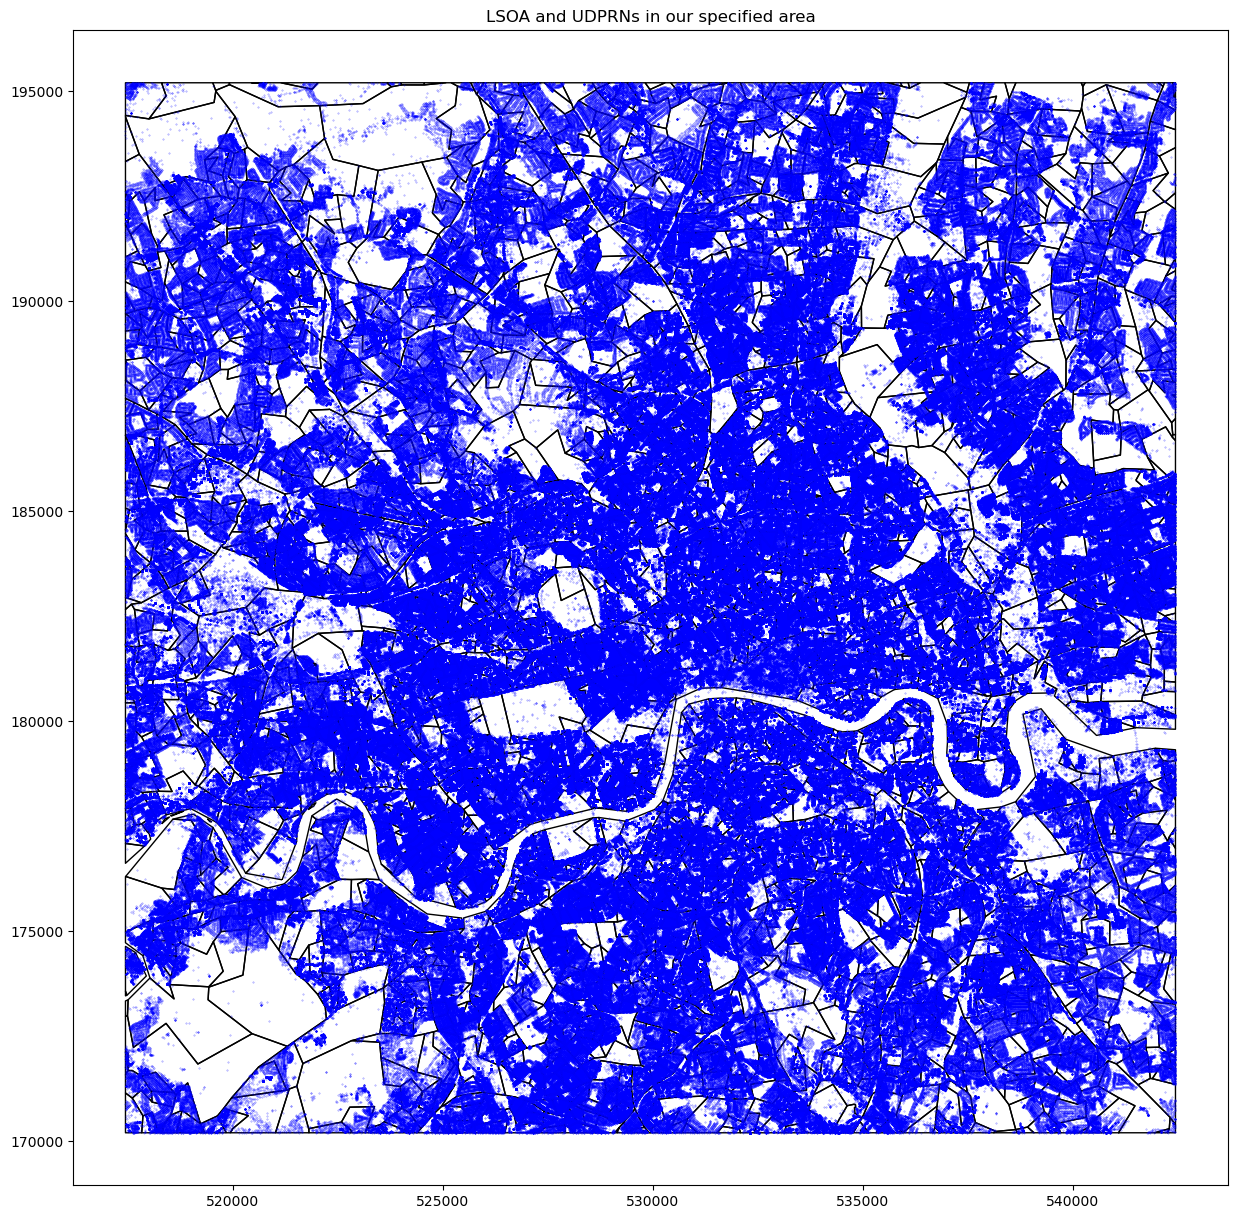

In [20]:
#for context, draw what we're trying to calculate

fig, ax = plt.subplots(1, figsize=(15,15))
plt.title("LSOA and UDPRNs in our specified area")
gdf.loc[gdf["Type"]=="LSOA",:].plot(ax=ax, color='none', edgecolor='black', zorder=1)
gdf.loc[gdf["Type"]=="UDPRNs",:].plot(ax=ax, color='blue', alpha = 0.5, markersize=0.1, zorder=2)
plt.show()

In [3]:
#Sample code 1 - counts the number of UDPRNs within each LSOA boundary box

def count_points_within_bound(points, boundary):
    count = [np.count_nonzero(points.loc[points.within(poly_geom),"Details_Float"].to_numpy()) for poly_geom in boundary.geometry]
    return count

%timeit -n 1 Sample_1_Method_original = count_points_within_bound(UDPRNs,LSOA)

Sample_1_Method_original = count_points_within_bound(UDPRNs,LSOA)

14.5 s ± 3.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# Start Ray. (only do this once)
ray.init()

2023-10-21 10:31:52,356	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.7.1
Dashboard:,http://127.0.0.1:8265


In [21]:
@ray.remote
def count_points_within_bound(points, boundary):
    count = [np.count_nonzero(points.loc[points.within(poly_geom),"Details_Float"].to_numpy()) for poly_geom in boundary.geometry]
    return count

# Start 6 tasks in parallel.
results_ray = []
for i in range(6):
    results_ray = results_ray + [count_points_within_bound.remote(UDPRNs,LSOA)]

In [22]:
Sample_1_Method_ray = ray.get(results_ray)[0]

KeyboardInterrupt: 

In [17]:
Sample_1_Method_original == Sample_1_Method_ray

True